In [150]:
%matplotlib inline

import os #'os' gives some 'operating system' type functionality
os.environ['USE_PYGEOS'] = '0'  #this is the recommended way to prevent a common geopandas warning

#geopandas and pandas
import geopandas
import pandas

#numpy!
import numpy as np

#a common plotting library
import matplotlib
import matplotlib.pyplot as plt


#rasterio...an alternative to 'gdal'. which one I use depends on the task.
import rasterio, rasterio.plot, rasterio.mask
from rasterio import plot as rasterplot
from rasterio.plot import plotting_extent

In [165]:
#open a rasterio dataset (raster)
#this raster is a canopy height model
raster_src = rasterio.open('./sswidths/494_6295_chm.tif')

raster_nodata = raster_src.nodata
raster_data = raster_src.read(1)
print(raster_src.crs)
print(f'nodatavalue: {raster_nodata}')

EPSG:2956
nodatavalue: -9999.0


In [154]:
#open the small seismic-lines shapefile
features = geopandas.read_file('./sswidths/seismic_lines.shp')
print(features.crs)

tiff_bounds = features.geometry[0].bounds
print(tiff_bounds)

epsg:26912
(494255.00000000093, 6295828.250000003, 494259.00000000093, 6295892.000000003)


In [155]:
#reproject the shapefile to the same as raster
features = features.to_crs('epsg:2956')
print(features.crs)


epsg:2956


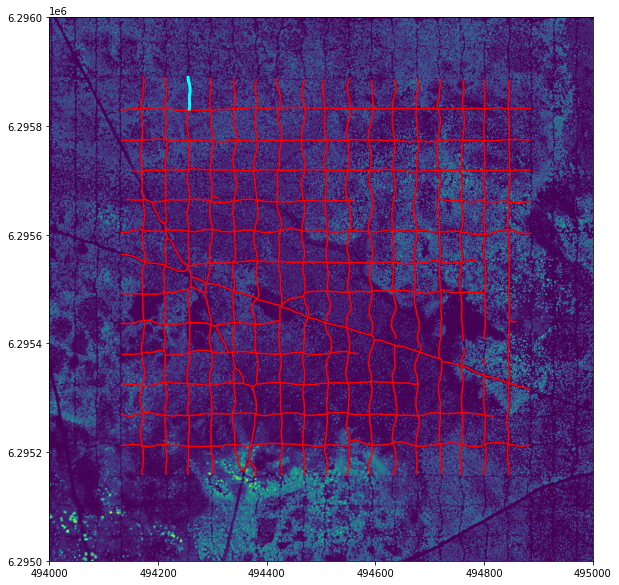

In [156]:

rbounds = raster_src.bounds
data_plotting_extent = [rbounds.left, rbounds.right, rbounds.bottom, rbounds.top]


#matplotlib can sometimes be mysterious to work with
#so can plotting rasters using rasterio
#I found a couple of good links with examples
#https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/plotting-extents/
#https://medium.com/analytics-vidhya/python-for-geosciences-raster-merging-clipping-and-reprojection-with-rasterio-9f05f012b88a

f, ax = plt.subplots(figsize=(10, 10))

rasterplot.show(raster_data, 
                extent=data_plotting_extent,
                ax=ax)

#plot the pandas dataframe over top, in red
features.plot(ax=ax, edgecolor='red')

#take the first feature and plot it in a different colour
geom = features.loc[0, 'geometry']
gs = geopandas.GeoSeries([geom])
gs.plot(ax=ax, edgecolor='cyan', linewidth=3)

plt.show()


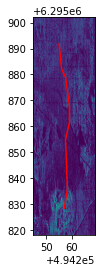

In [158]:
#try plotting just a little bit of the raster...defined by a buffer around the first geometry

#get first geometry
geom = features.loc[0, 'geometry']

#buffer it and grab the bounds
new_bounds = geom.buffer(10).bounds

#make a geoseries (it has the 'plot' method we can call)
gs = geopandas.GeoSeries([geom])

#using this function again...when plotting rasters this way, one needs to make an extent or else stuff breaks
data_plotting_extent = [new_bounds[0], new_bounds[2], new_bounds[1], new_bounds[3]]

f, ax = plt.subplots()
rasterplot.show(raster_data, 
                extent=data_plotting_extent,
                ax=ax)

gs.plot(ax=ax, edgecolor='red')

plt.show()

#just a fun little mini plot

mean chm value: 1.28
nodatas:
0
number of pixels
2010
shape
(1, 134, 15)
[[-- 0.040008544921875 0.07373046875]
 [0.09796142578125 0.0736083984375 0.075836181640625]
 [0.05963134765625 0.099639892578125 0.074859619140625]]


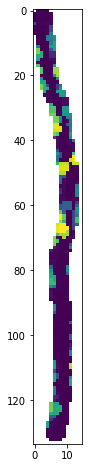

In [173]:
#in this cell, we want to grab the pixels in the raster that lay underneath a buffered geometry.
#we once again select the first geometry, buffer it, use a mask function to grab the pixels

#grab first geometry...highlit in cyan in the above map
geom = features.loc[0, 'geometry']
buff_geom = geom.buffer(1.5)

#tricky rasterio masking function
#it takes a list of geometries, that is why I put 'buff_geom' inside [square brackets]
chm_mask, _transform = rasterio.mask.mask(raster_src, [buff_geom], crop=True, filled=False)

#at this point, 'chm_mask' contains the pixels we want
buf_mean = np.mean(chm_mask[0])
print(f'mean chm value: {buf_mean:0.2f}')

#let's make sure there are no nodatas...
print('nodatas:')
print(np.sum(chm_mask == raster_nodata))

#how many pixels? 'ravel' turns a nd numpy array into one long list
print('number of pixels')
print(len(chm_mask.ravel()))

#and the mask's size
print('shape')
print(chm_mask.shape)

print(chm_mask[0, 0:3,0:3])
#interesting...it would appear that numpy can use blank cells indicated by '--' that don't factor in to any calculations
#neat.

plt.figure(figsize=(8, 8))
plt.imshow(chm_mask[0])
plt.show()

[0.5 0.6 0.7 0.8 0.9]


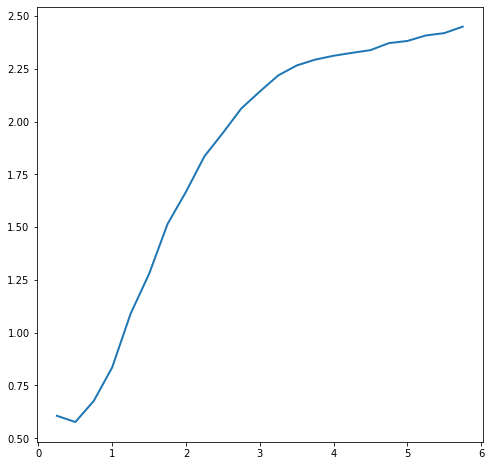

In [177]:
#now in this cell, we will do the above operation over and over...increasing the buffer each time
#and storing the buffer size along with the mean value of the mask

#grab first geometry...highlit in cyan in the above map
geom = features.loc[0, 'geometry']

#now loop and create buffers of varying size
#np.arange makes a bunch of values from, to, increment
print(np.arange(.5, 1, 0.1))

buf_val, mean_val = [], []
for buf in np.arange(.25, 6., 0.25):
    buf_val.append(buf)
    _chm_mask, _transform = rasterio.mask.mask(raster_src, [geom.buffer(buf)], crop=True, filled=False)
    mean_val.append(np.mean(_chm_mask[0]))


fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(buf_val, mean_val, linewidth=2.0)
plt.show()

by this plot, you can see that the first 2 points(corresponding to 0.25 and 0.5 for buffer)
have a very low mean value. when the buffer value gets to about 0.75/1.0, the mean value starts shooting up.
Taking 1m, that would correspond to a width of 2m.  
This is one of the approaches I plan on taking to calculate the widths of seismic lines once I get the centerlines.

for each line in shapefile (with 100,000s of seismic lines)
   do the above loop.

quite computationally intensive. We'll see how it goes.